In [7]:
import vice
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
from python_packages.plotting.cdf import plot_cdf
import random
import seaborn as sns



In [8]:
def analogdata(filename):
    # from VICE/src/utils
    # last column of analogdata is z_height_final
    data = []
    with open(filename, 'r') as f:
        line = f.readline()
        while line[0] == '#':
            line = f.readline()
        while line != '':
            line = line.split()
            data.append([int(line[0]), float(line[1]), float(line[-1])])
            line = f.readline()
        f.close()
    return data

def calculate_z(output):
    analog_data = analogdata(output.name + "_analogdata.out")
    return [np.abs(row[-1]) for row in analog_data][:output.stars.size[0]]

def sample_stars(stars, num=1000):
    r"""
    Samples a population of stars while respecting mass weights
    
    Parameters
    ----------
    stars: the stars attribute from vice.output
    num: (int) the number of stars to sample
    
    Returns
    -------
    A np.array of the sampled parameter from stars
    """
    size = len(stars.todict()["mass"])
    result = {key: np.zeros(num) for key in stars.keys()}
        
    index = random.choices(np.arange(size), weights=stars["mass"], k=num)
    for i in range(num):
        for key in stars.keys():
            result[key][i] = stars[key][index[i]]
    return vice.dataframe(result)

In [27]:
def filter_stars(stars, R_min, R_max, z_min=0, z_max=2):
    return stars.filter("zone_final", ">", R_to_zone(R_min)).filter(
        "zone_final", "<", R_to_zone(R_max)).filter(
        "abs_z", ">", z_min).filter(
        "abs_z", "<", z_max)


def show_stars(stars, x="[fe/h]", y=None, c=None, s=1, alpha=1, kde=False, ax=None, fig=None, **args):
    if ax is None or fig is None:
        fig, ax = plt.subplots()
        
    if kde:
        sns.kdeplot(stars[x], **args)
    elif y is None:
        ax.hist(stars[x], **args)
        ax.set_ylabel("count")
    else:
        if c is None:
            ax.scatter(stars[x], stars[y], s=s, alpha=alpha, **args)

        else:
            ax.scatter(stars[x], stars[y], c=stars[c], s=s, alpha=alpha, **args)
        
        ax.set_ylabel(y)
    ax.set_xlabel(x)


In [40]:
# load in models from files

inside_out = vice.output("VICE/migration/outputs/diffusion/insideout")
late_burst = vice.output("VICE/migration/outputs/diffusion/lateburst")
outer_burst = vice.output("VICE/migration/outputs/diffusion/outerburst")
late_burst_small = vice.output("VICE/migration/outputs/diffusion/lateburst_0_5")
late_burst_big = vice.output("VICE/migration/outputs/diffusion/lateburst_2_5")

for model_ in [inside_out, outer_burst, late_burst_small, late_burst_big]:
    model_.stars["abs_z"] = calculate_z(model_)


In [10]:
zone_width=0.1
def R_to_zone(r: float):
    return 1 + round(r/zone_width)
def zone_to_R(zone: int):
    return (zone) * zone_width

max_zone = 155
stars = sample_stars(inside_out.stars.filter("zone_origin", "<", max_zone), num=10_000)

(-1.2, 1.0452464526958534)

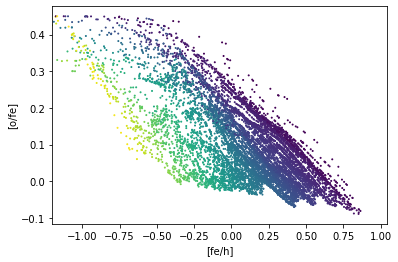

In [29]:
show_stars(stars, "[fe/h]", "[o/fe]", c="zone_origin")
plt.xlim(-1.2)

In [36]:
plt.subplots?

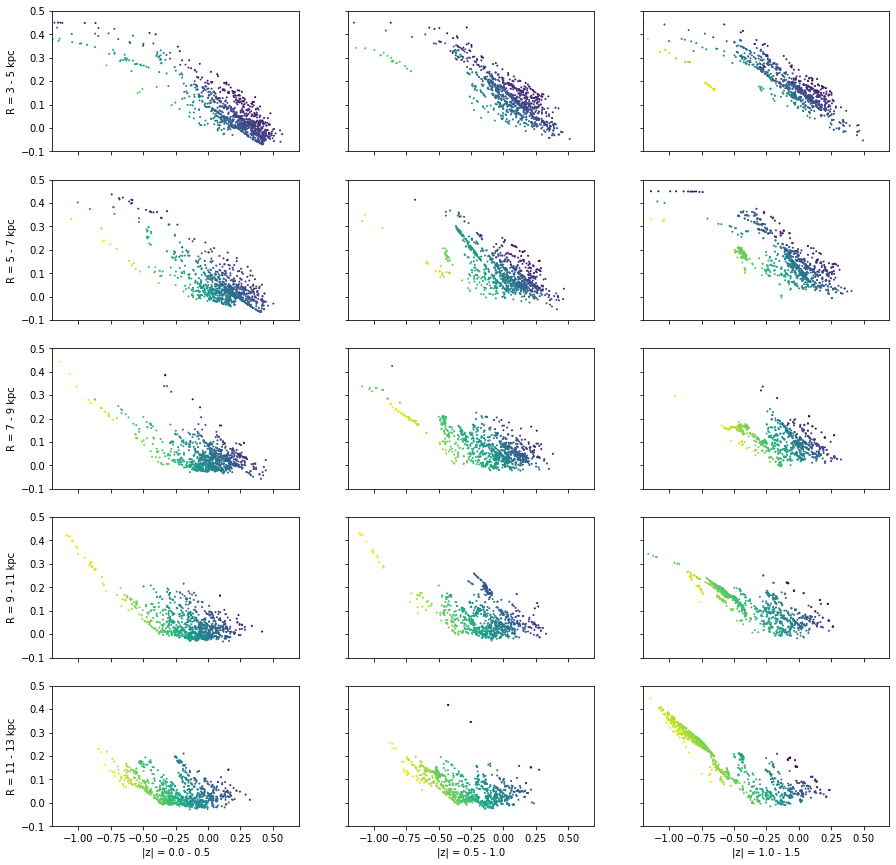

In [39]:
fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(15,15))

for j in range(5):
    R_min, R_max = [(3,5), (5,7), (7,9), (9,11), (11,13)][j]
    
    for i in range(3):
        z_min, z_max = [(0, 0.5), (0.5, 1), (1, 1.5)][i]
        filtered = sample_stars(filter_stars(inside_out.stars, R_min, R_max, z_min, z_max), num=1000)
        
        ax = axs[j][i]
        show_stars(filtered, "[fe/h]", "[o/fe]", c="zone_origin", fig=fig, ax=ax)
        ax.set(xlim=(-1.2, 0.7),
               ylim=(-0.1,0.5),
               xlabel="",
               ylabel=""
              )
        if i == 0:
            ax.set(ylabel="R = %i - %i kpc" %(R_min, R_max))
        if j == 4:
            ax.set(xlabel="|z| = %1.1f - %1.1f" % (z_min, z_max))
        

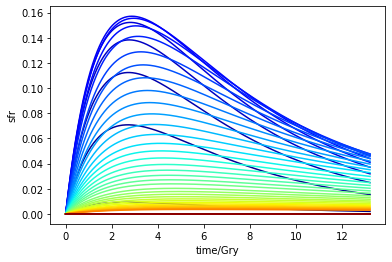

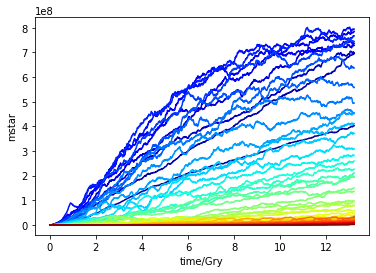

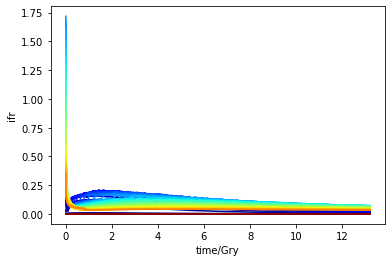

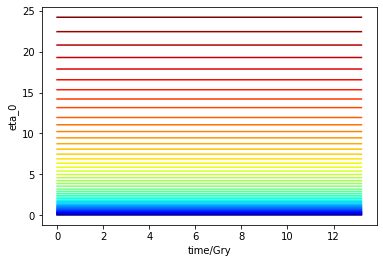

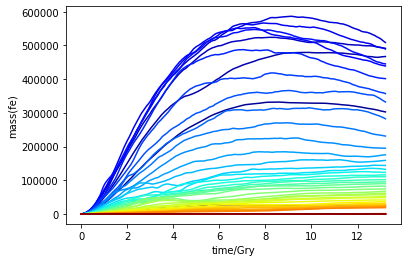

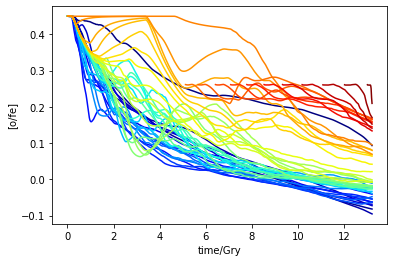

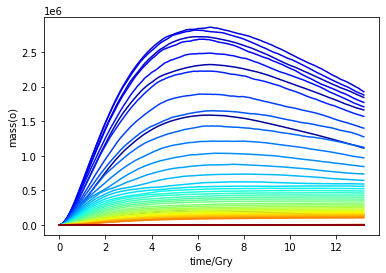

In [8]:
cmap = plt.get_cmap('jet')

N=50
for var in ["sfr", "mstar", "ifr", "eta_0", "mass(fe)", "[o/fe]", "mass(o)"]:
    for zone in np.round(np.linspace(0, 199, N)):
        x = inside_out.zones["zone%i" % zone].history["time"]
        y = inside_out.zones["zone%i" % zone].history[var]
        plt.plot(x, y, color=cmap(zone/200), label="R_gal = %2.1f" % zone_to_R(zone))

        plt.xlabel("time/Gry")
        plt.ylabel(var)
        #plt.legend()
    plt.show()
    

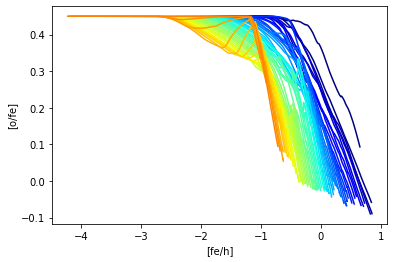

In [9]:
cmap = plt.get_cmap('jet')

N=50
for zone in np.round(np.linspace(0, 154, N)):
    x = inside_out.zones["zone%i" % zone].history["[fe/h]"]
    y = inside_out.zones["zone%i" % zone].history["[o/fe]"]
    plt.plot(x, y, color=cmap(zone/200), label="R_gal = %2.1f" % zone_to_R(zone))

    plt.xlabel("[fe/h]")
    plt.ylabel("[o/fe]")
    #plt.legend()

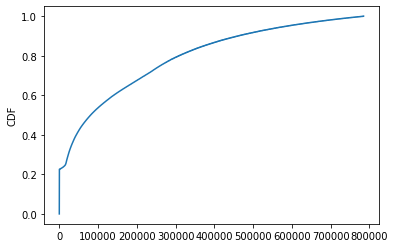

In [10]:
plot_cdf(inside_out.stars["mass"])

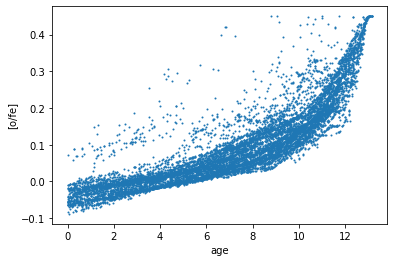

In [11]:
show_stars(stars, x="age", y="[o/fe]")

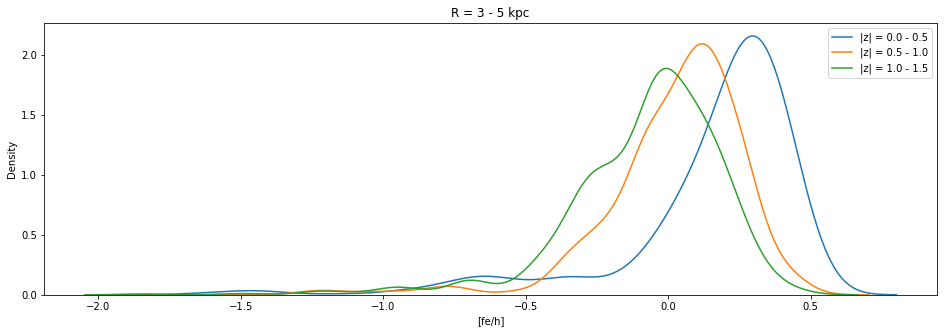

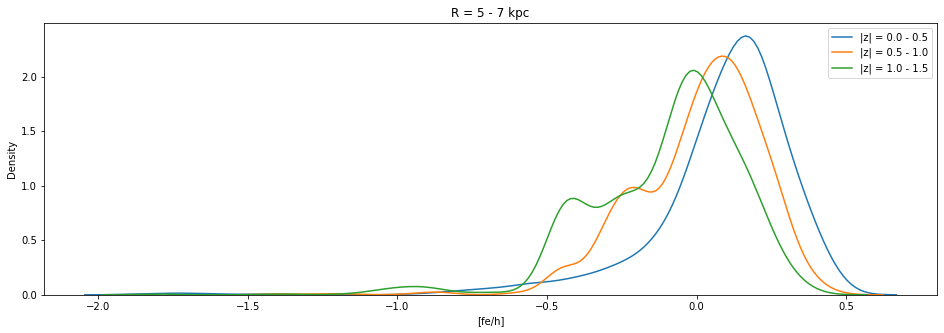

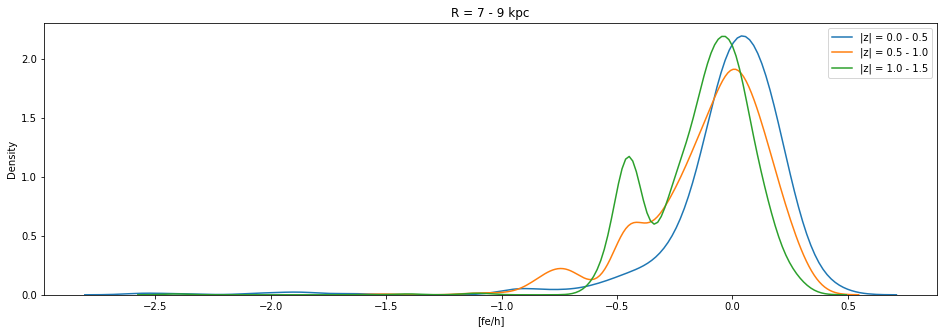

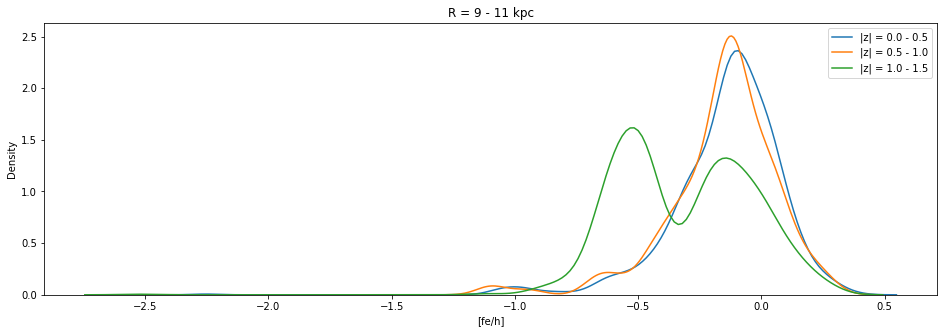

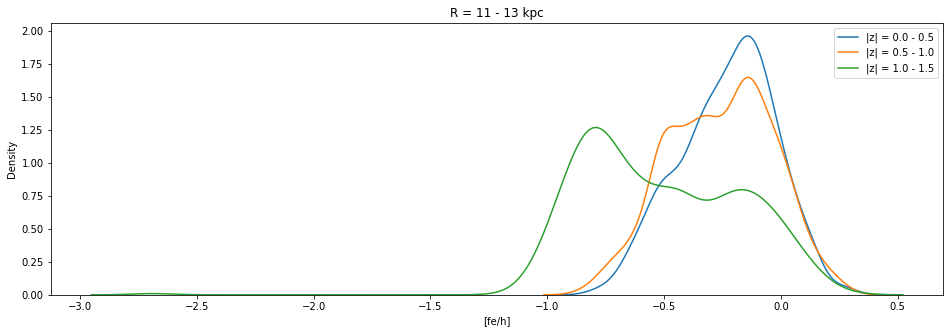

In [12]:
for R_min, R_max in [(3,5), (5,7), (7,9), (9,11), (11,13)]:
    plt.figure(figsize=(16,5))
    
    for i in range(3):
        z_min, z_max = [(0, 0.5), (0.5, 1), (1, 1.5)][i]
        filtered = sample_stars(filter_stars(inside_out.stars, R_min, R_max, z_min, z_max), num=1000)
        show_stars(filtered, "[fe/h]", label="|z| = %1.1f - %1.1f" % (z_min, z_max), kde=True)
    plt.title("R = %i - %i kpc" %(R_min, R_max))
    plt.legend()

    plt.show()

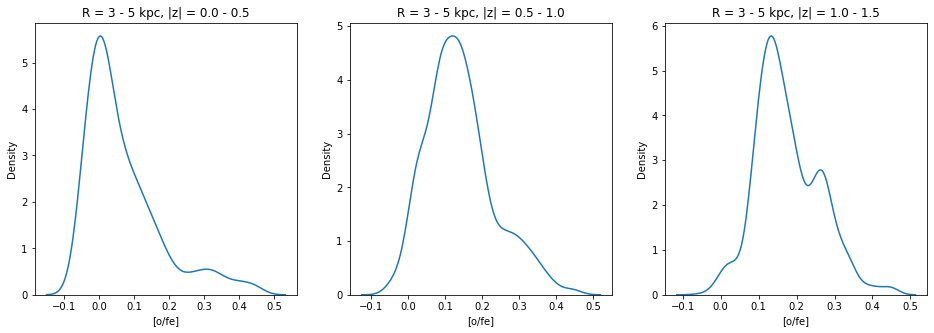

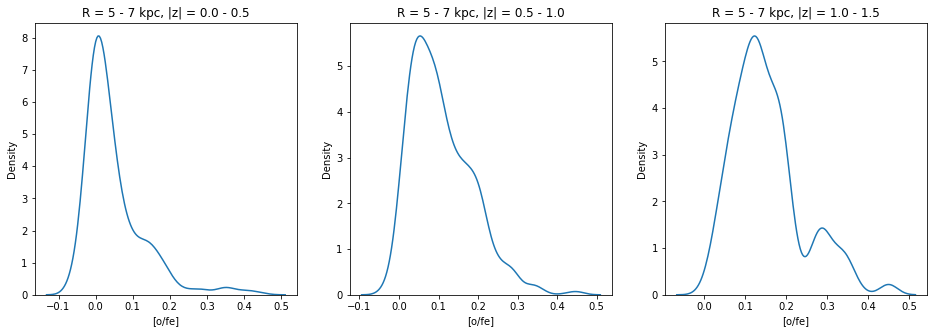

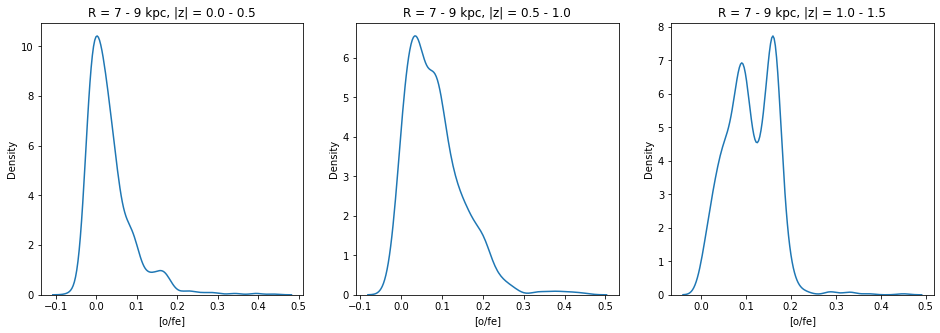

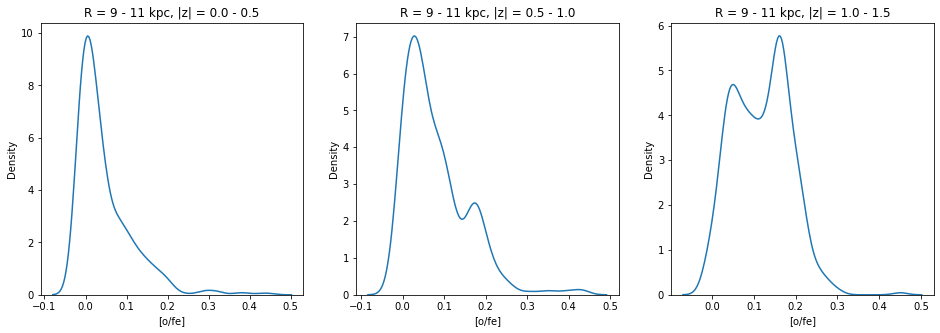

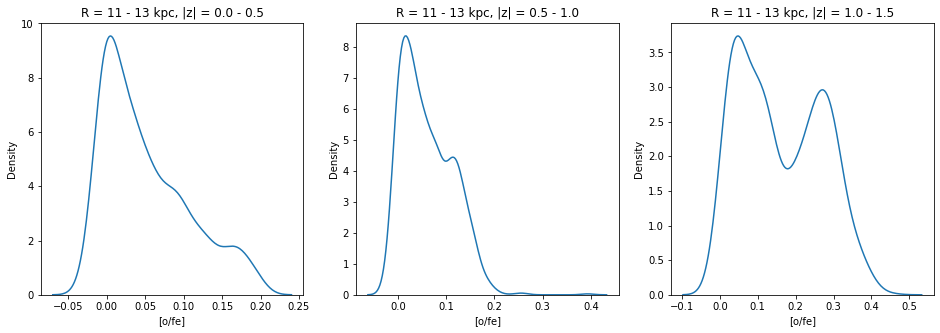

In [13]:
# these plots need fixed since we should sample from stellar populations with probability proportional to mass :(
for R_min, R_max in [(3,5), (5,7), (7,9), (9,11), (11,13)]:
    plt.figure(figsize=(16,5))
    
    for i in range(3):
        z_min, z_max = [(0, 0.5), (0.5, 1), (1, 1.5)][i]
        filtered = sample_stars(filter_stars(inside_out.stars, R_min, R_max, z_min, z_max), num=1000)
        plt.subplot(1,3,i+1)
        show_stars(filtered, "[o/fe]", label="|z| = %1.1f - %1.1f" % (z_min, z_max), kde=True)
        plt.title("R = %i - %i kpc, |z| = %1.1f - %1.1f" %(R_min, R_max, z_min, z_max))
    plt.show()
    


In [14]:
stars

vice.dataframe{
    formation_time -> [10.02, 2.8, 2.31, ... , 8.36, 2.62, 5.14]
    zone_origin ----> [104, 24, 14, ... , 20, 79, 27]
    zone_final -----> [116, 35, 17, ... , 26, 45, 29]
    mass -----------> [79991.7, 776298, 722792, ... , 430824, 193191, 663749]
    z(fe) ----------> [0.000756127, 0.00170665, 0.00147641, ... , 0.00386464, 0.000664389, 0.00274483]
    z(o) -----------> [0.00347504, 0.0108904, 0.0110154, ... , 0.0180359, 0.00459389, 0.0135751]
    abs_z ----------> [0.81, 0.74, 0.17, ... , 0.1, 0.24, 0.07]
    [fe/h] ---------> [-0.231995, 0.121554, 0.0586158, ... , 0.476519, -0.288168, 0.327925]
    [o/h] ----------> [-0.216436, 0.27965, 0.284606, ... , 0.498741, -0.0952151, 0.375346]
    [o/fe] ---------> [0.015559, 0.158096, 0.22599, ... , 0.022222, 0.192952, 0.0474208]
    z --------------> [0.00845027, 0.0251583, 0.0249481, ... , 0.0437386, 0.0105016, 0.0325932]
    [m/h] ----------> [-0.219258, 0.254552, 0.250909, ... , 0.494736, -0.124874, 0.366999]
    age --

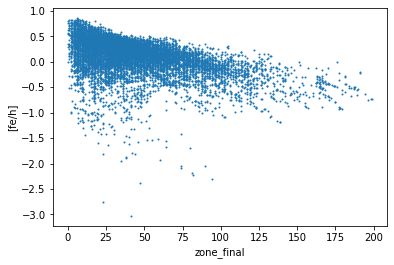

In [15]:
show_stars(stars, "zone_final", "[fe/h]")

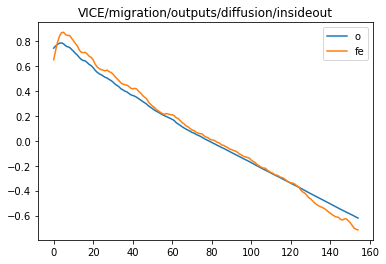

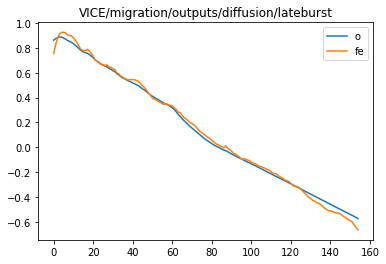

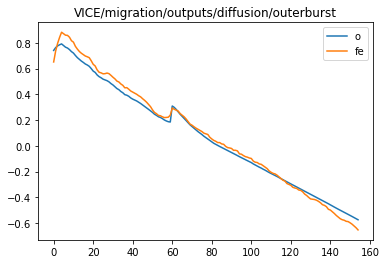

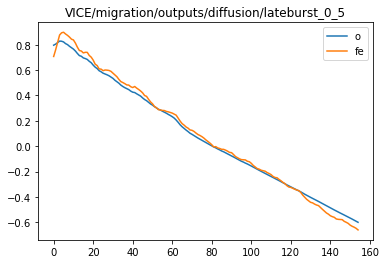

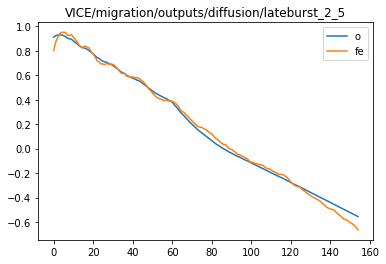

In [53]:
for model_ in [inside_out, late_burst, outer_burst, late_burst_small, late_burst_big]:
    for element in ["o", "fe"]:
        o_per_zone = [model_.zones["zone%i" % i].history["[%s/h]" % element][-1] for i in range(0, 155)]
        plt.plot(np.arange(0,155), o_per_zone, label=element)
    plt.legend()
    plt.title(model_.name)
    plt.show()

<Figure size 576x288 with 0 Axes>

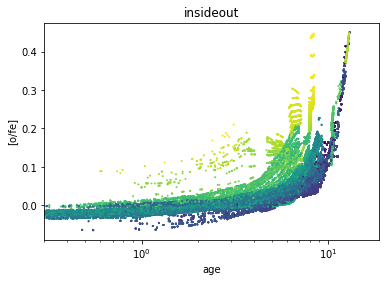

<Figure size 576x288 with 0 Axes>

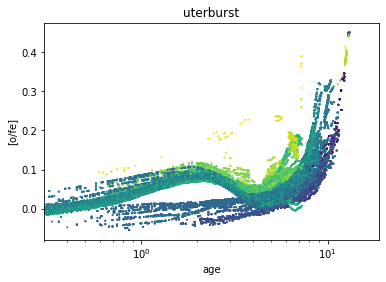

<Figure size 576x288 with 0 Axes>

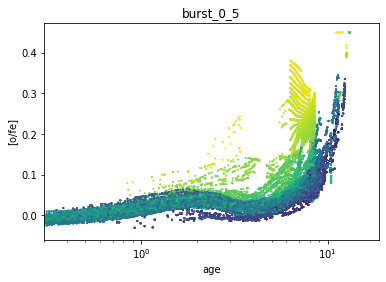

<Figure size 576x288 with 0 Axes>

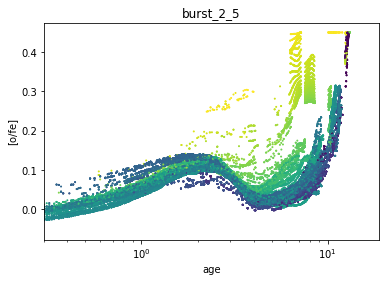

In [52]:
for model_ in [inside_out, outer_burst, late_burst_small, late_burst_big]:
    plt.figure(figsize=(8,4))
    show_stars(sample_stars(filter_stars(model_.stars, 7, 9, 0, 0.5), 10**5), "age", "[o/fe]", c="zone_origin")
    plt.title(model_.name[-9:])
    plt.xscale("log")
    plt.xlim(0.3)
    plt.show()

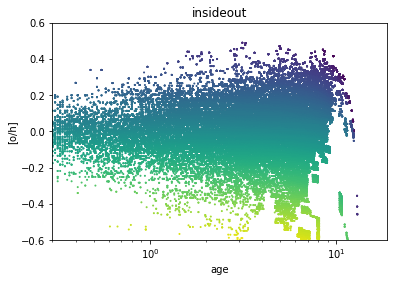

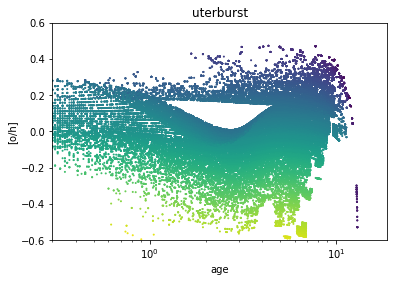

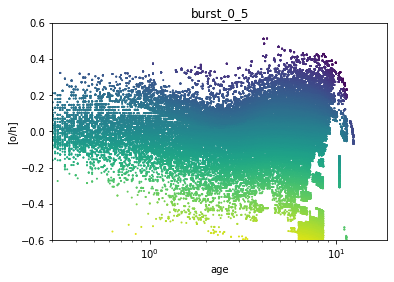

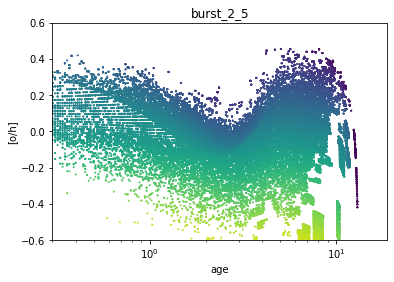

In [51]:
for model_ in [inside_out, outer_burst, late_burst_small, late_burst_big]:
    show_stars(sample_stars(filter_stars(model_.stars, 7, 9, 0, 0.5), 10**5), "age", "[o/h]", c="zone_origin")
    plt.title(model_.name[-9:])
    plt.xscale("log")
    plt.xlim(0.3)
    plt.ylim(-0.6, 0.6)
    plt.show()

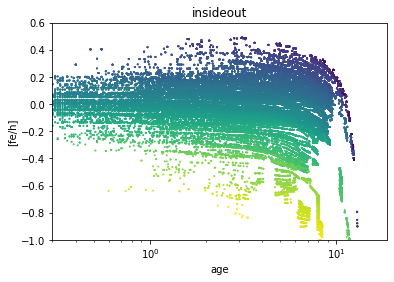

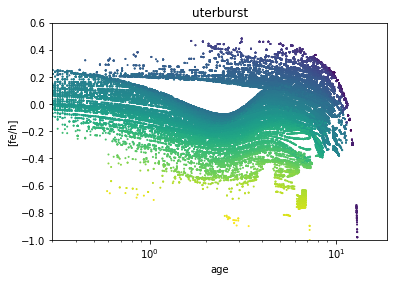

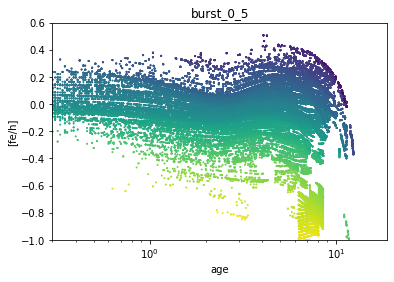

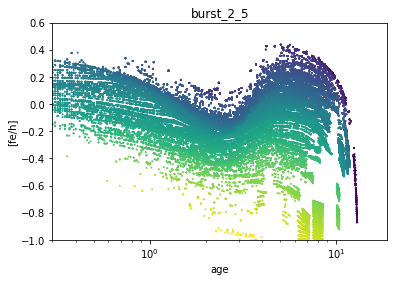

In [50]:
for model_ in [inside_out, outer_burst, late_burst_small, late_burst_big]:
    show_stars(sample_stars(filter_stars(model_.stars, 7, 9, 0, 0.5), 10**5), "age", "[fe/h]", c="zone_origin")
    plt.title(model_.name[-9:])
    plt.xscale("log")
    plt.xlim(0.3)
    plt.ylim(-1, 0.6)
    plt.show()

In [54]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        